# Exercice 1: Simplificaiton du vocabulaire

## a) Génération des données et étiquettes

In [1]:
bStart = False
fin = open("/kaggle/input/fleurs-du-mal/fleurs_mal.txt", 'r' , encoding = 'utf8')
lines = fin.readlines()
lines2 = []
text = []

for line in lines:
 line = line.strip().lower() # Remove blanks and capitals
 if("Charles Baudelaire avait un ami".lower() in line and bStart==False):
  print("START")
  bStart = True
 if("End of the Project Gutenberg EBook of Les Fleurs du Mal, by Charles Baudelaire".lower() in line):
  print("END")
  break
 if(bStart==False or len(line) == 0):
  continue
 lines2.append(line)

fin.close()
text = " ".join(lines2)
chars = sorted(set([c for c in text]))
nb_chars = len(chars)

START
END


**Interprétation des variables :**

- `chars` : Cette variable est une **liste de tous les caractères uniques présents dans le texte** après le pré-traitement (minuscules et suppression des espaces superflus). Elle représente donc l’**alphabet utilisé par le modèle** pour générer du texte. Par exemple, elle contient toutes les lettres, les signes de ponctuation et les espaces utilisés dans le recueil.

- `nb_chars` : Cette variable correspond au **nombre total de caractères uniques** dans le texte, c’est-à-dire la **taille de l’alphabet** que le réseau de neurones devra gérer pour la génération de texte.


In [19]:
SEQLEN = 10 # Length of the sequence to predict next char
STEP = 1 # stride between two subsequent sequences
input_chars = []
label_chars = []
for i in range(0, len(text) - SEQLEN, STEP):
 # Append input of size SEQLEN
    input_chars.append(text[i: i + SEQLEN])
 # Append output (label) of size 1
    label_chars.append(text[i+SEQLEN])
nbex = len(input_chars)

In [20]:
# mapping char -> index in dictionary: used for encoding (here)
char2index = dict((c, i) for i, c in enumerate(chars))
# mapping char -> index in dictionary: used for decoding, i.e. generation - part c)
index2char = dict((i, c) for i, c in enumerate(chars)) # mapping index -> char in dictionary

In [21]:
import numpy as np
X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=np.bool)
y = np.zeros((len(input_chars), nb_chars), dtype=np.bool)

for i, input_char in enumerate(input_chars):
    for j, ch in enumerate(input_char):
  # Fill X at correct index
        X[i,j,char2index[ch]] = 1
 # Fill y at correct index
    y[i,char2index[label_chars[i]]] = 1


## Train and test splitting

In [22]:
import _pickle as pickle

ratio_train = 0.8
nb_train = int(round(len(input_chars)*ratio_train))
print("nb tot=",len(input_chars) , "nb_train=",nb_train)
X_train = X[0:nb_train,:,:]
y_train = y[0:nb_train,:]

X_test = X[nb_train:,:,:]
y_test = y[nb_train:,:]
print("X train.shape=",X_train.shape)
print("y train.shape=",y_train.shape)

print("X test.shape=",X_test.shape)
print("y test.shape=",y_test.shape)

outfile = "Baudelaire_len_"+str(SEQLEN)+".p"

with open(outfile, "wb" ) as pickle_f:
 pickle.dump( [index2char, X_train, y_train, X_test, y_test], pickle_f)

nb tot= 146166 nb_train= 116933
X train.shape= (116933, 10, 60)
y train.shape= (116933, 60)
X test.shape= (29233, 10, 60)
y test.shape= (29233, 60)


## b) Apprentissage d’un modèle auto-supervisé pour la génération de texte

In [23]:
SEQLEN = 10
outfile = "Baudelaire_len_"+str(SEQLEN)+".p"
[index2char, X_train, y_train, X_test, y_test] = pickle.load( open( outfile, "rb" ) )

In [24]:
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, RMSprop

model = Sequential()
HSIZE = 128
model.add(SimpleRNN(HSIZE, return_sequences=False, input_shape=(SEQLEN, nb_chars),unroll=True))
model.add(Dense(nb_chars))
model.add(Activation('softmax'))


BATCH_SIZE = 128
NUM_EPOCHS = 50
learning_rate = 0.001
optimizer = RMSprop(learning_rate)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 128)            │        24,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 60)             │         7,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,932 (124.73 KB)

 Trainable params: 31,932 (124.73 KB)

 Non-trainable params: 0 (0.00 B)

**Explication de `return_sequences=False` :**  

Dans un réseau de neurones récurrent (RNN), chaque cellule produit une sortie à chaque pas de temps. L’argument `return_sequences` détermine ce que le RNN renvoie :  

- `return_sequences=False` : le RNN ne renvoie **que la sortie du dernier pas de temps**. Cela est utile lorsque l’on s’intéresse uniquement au résultat final de la séquence, par exemple pour la classification ou la prédiction du prochain élément dans une série.  
- `return_sequences=True` : le RNN renvoie **toutes les sorties de chaque pas de temps**, produisant donc une séquence complète de sorties, utile lorsqu’on veut que la couche suivante traite l’intégralité de la séquence.  


In [25]:
model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS)
scores_train = model.evaluate(X_train, y_train, verbose=1)
scores_test = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2497 - loss: 2.6895
Epoch 2/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3444 - loss: 2.2005
Epoch 3/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3621 - loss: 2.1190
Epoch 4/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3766 - loss: 2.0562
Epoch 5/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3914 - loss: 2.0090
Epoch 6/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3997 - loss: 1.9726
Epoch 7/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4151 - loss: 1.9227
Epoch 8/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4250 - loss: 1.8962
Epoch 9/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4324 - loss: 1.8569
Epoch 10/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4413 - loss: 1.8337
Epoch 11/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4483 - loss: 1.8043
Epoch 12/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

In [27]:
print("PERFS TRAIN: %s: %.2f%%" % (model.metrics_names[1], scores_train[1]*100))
print("PERFS TEST: %s: %.2f%%" % (model.metrics_names[1], scores_test[1]*100))

PERFS TRAIN: compile_metrics: 53.71%
PERFS TEST: compile_metrics: 46.35%


In [30]:
def saveModel(model, savename):
  # serialize model to JSON
  model_json = model.to_json()
  # Save as .json (Standard replacement for .yaml)
  with open(savename+".json", "w") as json_file:
    json_file.write(model_json)
    print("JSON Model ",savename,".json saved to disk")
  # serialize weights to HDF5
  model.save_weights(savename+".weights.h5")
  print("Weights ",savename,".h5 saved to disk")

saveModel(model, 'RNN')

JSON Model  RNN .json saved to disk
Weights  RNN .h5 saved to disk


In [65]:
sentence_idx = []
for chars in input_chars:
    if chars ==  'la mort de':
        sentence_idx.append(1)
    else:
        sentence_idx.append(0)

outputs = []
for i, label in enumerate(label_chars):
    if sentence_idx[i] == 1:
        outputs.append(label)
outputs

[' ', ' ', 's', 's']

**Taux de classification et commentaires :**  

- **Performance sur l’apprentissage (train) :** 53,71 %  
- **Performance sur le test :** 46,35 %  

Les performances sont relativement modestes. Cela s’explique par la **nature séquentielle et complexe du texte poétique**, où le RNN doit apprendre des relations à long terme entre les caractères. La génération de texte est plus difficile qu’une classification classique car chaque caractère dépend fortement du contexte précédent, contrairement aux problèmes de classification simples où chaque exemple est indépendant.  

**Différence avec les problèmes de classification classiques :**  

- Ici, le modèle ne prédit pas une **classe fixe** pour un exemple isolé, mais un **prochain caractère** à partir d’une séquence précédente.  
- En recherchant la séquence `"la mort de"` dans le corpus d’apprentissage, on observe que **les labels cibles (les caractères suivants) varient beaucoup** selon le contexte poétique. Par exemple, après `"la mort de"`, on peut trouver différents caractères ou mots suivant le poème. Cette variabilité rend la prédiction plus difficile et explique le taux de classification plus faible.  
- De plus, dans cet exemple précis, la séquence cible est `[' ', ' ', 's', 's']`, avec **2 espaces et 2 lettres "s"**. Il est donc **logique que la précision soit proche de 50 %**, car le modèle peut facilement se tromper entre ces deux types de caractères.  



## c) Génération de texte avec le modèle appris

In [28]:
SEQLEN = 10
outfile = "Baudelaire_len_"+str(SEQLEN)+".p"
[index2char, X_train, y_train, X_test, y_test] = pickle.load( open( outfile, "rb" ) )


from keras.models import model_from_json

def loadModel(savename):
  # Read the .json file
  with open(savename+".json", "r") as json_file:
    model = model_from_json(json_file.read())
  print("JSON Model ",savename,".json loaded ")
  
  model.load_weights(savename+".weights.h5")
  print("Weights ",savename,".h5 loaded ")
  return model

In [31]:
model = loadModel('RNN')
model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics=['accuracy'])
model.summary()
nb_chars = len(index2char)

JSON Model  RNN .json loaded 
Weights  RNN .h5 loaded 


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 128)            │        24,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 60)             │         7,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,932 (124.73 KB)

 Trainable params: 31,932 (124.73 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
seed =1508
char_init = ""
for i in range(SEQLEN):
 char = index2char[np.argmax(X_train[seed,i,:])]
 char_init += char

print("CHAR INIT: "+char_init)

test = np.zeros((1, SEQLEN, nb_chars), dtype=np.bool)
test[0,:,:] = X_train[seed,:,:]

def sampling(preds, temperature=1.0):
 preds = np.asarray(preds).astype('float64')
 predsN = pow(preds,1.0/temperature)
 predsN /= np.sum(predsN)
 probas = np.random.multinomial(1, predsN, 1)
 return np.argmax(probas)

CHAR INIT: connaître 


**Comportement de l’échantillonnage en fonction de la température T :**  

L’échantillonnage utilise la **distribution softmax modifiée par la température** pour choisir le caractère suivant. Le paramètre `temperature` contrôle la « créativité » ou la « diversité » des prédictions :

- **Lorsque T → 0 (température très faible)** :  
  - La distribution devient **très piquée** autour de la valeur maximale.  
  - Le modèle **choisit presque toujours le caractère ayant la probabilité la plus élevée**.  
  - Le texte généré est **très prévisible et répétitif**, mais grammaticalement plus cohérent.  

- **Lorsque T → +∞ (température très élevée)** :  
  - La distribution devient **quasi uniforme**, toutes les probabilités tendent à se rapprocher.  
  - Le choix du caractère devient **quasi aléatoire**, indépendamment des probabilités initiales.  
  - Le texte généré devient **très diversifié mais incohérent** ou grammaticalement incorrect.  

**Conclusion :**  
- **Basse température** → texte sûr mais monotone.  
- **Haute température** → texte créatif mais risqué.  
- La température permet donc d’équilibrer **créativité et cohérence** dans la génération de texte.


In [35]:
nbgen = 400 # number of characters to generate (1,nb_chars)
gen_char = char_init
temperature  = 0.1

for i in range(nbgen):
 preds = model.predict(test)[0]  # shape (1,nb_chars)
 next_ind = sampling(preds, temperature)
 next_char = index2char[next_ind]
 gen_char += next_char
 for i in range(SEQLEN-1):
  test[0,i,:] = test[0,i+1,:]
 test[0,SEQLEN-1,:] = 0
 test[0,SEQLEN-1,next_ind] = 1

print("Generated text: "+gen_char)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [36]:
print("Generated text: "+gen_char)

Generated text: connaître er des chambeau du souvent en ma fond des charmes de la connelle comme un mort les passes des plus que des rouverait l'amour d'un pas le soleil comme un parfum la chante des rouverait les charmes et la saintile que le coeur de ma ne veux, que le ses pas sons les passes des plus que des rougerai ma mondeurs que des rouveraus qui nous ces charmant de la vie la plaire par les couleurs de l'armire au 


**Impact du paramètre de température et du nombre d’époques sur la génération de texte :**  

1. **Impact de la température :**  
   - **T = 0,1 (température très faible)** :  
     - Le texte généré est **prévisible et cohérent**, avec peu d’erreurs de syntaxe ou de caractères inattendus.  
     - Cependant, le texte est **monotone et peu créatif**, souvent répétitif.  
     - Exemple : répétition de motifs comme « les passes des plus que des rouverait… ».  

   - **T = 0,99 (température proche de 1)** :  
     - Le texte devient **plus varié et surprenant**, parfois créatif ou poétique.  
     - Mais il contient beaucoup de **caractères incohérents ou de mots inventés**, rendant la lecture plus difficile.  
     - Exemple : « l'abpileure », « biani auloir ir point lanche », qui sont des séquences non existantes dans le corpus.  

   - **Conclusion** : La température permet de **contrôler le compromis entre créativité et cohérence**. Une température intermédiaire (≈0,5) est souvent utilisée pour un bon équilibre.

2. **Impact du nombre d’époques :**  
   - Avec **très peu d’époques**, le modèle n’a pas le temps d’apprendre correctement les séquences, ce qui conduit à **des résultats médiocres** et à un texte incohérent.  
   - En augmentant le nombre d’époques, la performance **s’améliore rapidement au début**, mais après un certain point, **les gains deviennent très faibles** (loi des rendements décroissants).  
   - Ainsi, **ajouter trop d’époques n’augmente la qualité que marginalement**, tout en augmentant le temps d’entraînement.

3. **Points forts du générateur :**  
   - Capable de **produire du texte dans le style du poème**.  
   - Peut **apprendre des séquences complexes** et générer des suites logiques de caractères.  
   - Permet d’**explorer la créativité du modèle** grâce à la température.

4. **Points faibles du générateur :**  
   - **Texte souvent incohérent** à haute température.  
   - La génération reste **limitée par la taille de la séquence d’entrée et le contexte appris**.  
   - Le modèle peut produire **des répétitions ou des séquences sans sens**.


# Exercice 2 : Embedding Vectoriel de texte

## a) Extraction des embedding Glove des légendes

In [45]:
import pandas as pd

# Load the data
df = pd.read_csv('/kaggle/input/flickr8k/captions.txt')

allwords = []
for caption in df['caption']:
    # Convert to string to avoid errors if a caption is missing (NaN)
    caption_text = str(caption) 
    # Split into words
    cap_words = caption_text.split()
    # Remove capital letters
    cap_wordsl = [w.lower() for w in cap_words]
    # Add to list
    allwords.extend(cap_wordsl)

unique = list(set(allwords)) # List of different words
print(len(unique))

8918


In [46]:
GLOVE_MODEL = "/kaggle/input/glove6b100dtxt/glove.6B.100d.txt"
fglove = open(GLOVE_MODEL, "r")

import numpy as np

listwords = []
listembeddings = []
cpt=0
for line in fglove:
    row = line.strip().split()
    word = str(row[0])
    if(word in unique or word=='unk'):
        listwords.append(word)
        # embedding = COMPLETE WITH YOUR CODE - use a numpy array with dtype="float32"
        embedding = np.array(row[1:], dtype = 'float32')
        listembeddings.append(embedding)
        cpt +=1
        print("word: "+word+" embedded "+str(cpt))

fglove.close()
nbwords = len(listembeddings)
tembedding = len(listembeddings[0])
print("Number of words="+str(len(listembeddings))+" Embedding size="+str(tembedding))

word: the embedded 1
word: , embedded 2
word: . embedded 3
word: of embedded 4
word: to embedded 5
word: and embedded 6
word: in embedded 7
word: a embedded 8
word: " embedded 9
word: 's embedded 10
word: for embedded 11
word: - embedded 12
word: that embedded 13
word: on embedded 14
word: is embedded 15
word: was embedded 16
word: with embedded 17
word: he embedded 18
word: as embedded 19
word: it embedded 20
word: by embedded 21
word: at embedded 22
word: ( embedded 23
word: ) embedded 24
word: from embedded 25
word: his embedded 26
word: an embedded 27
word: be embedded 28
word: has embedded 29
word: are embedded 30
word: have embedded 31
word: but embedded 32
word: were embedded 33
word: not embedded 34
word: this embedded 35
word: who embedded 36
word: they embedded 37
word: had embedded 38
word: i embedded 39
word: which embedded 40
word: will embedded 41
word: their embedded 42
word: : embedded 43
word: or embedded 44
word: its embedded 45
word: one embedded 46
word: after embed

In [47]:
embeddings = np.zeros((len(listembeddings)+2,tembedding+2))
for i in range(nbwords):
 embeddings[i,0:tembedding] = listembeddings[i]
    
listwords.append('<start>')
embeddings[nbwords, tembedding] = 1 
listwords.append('<end>')
embeddings[nbwords + 1, tembedding + 1] = 1

In [48]:
import _pickle as pickle

outfile = 'Caption_Embeddings.p'
with open(outfile, "wb" ) as pickle_f:
 pickle.dump( [listwords, embeddings], pickle_f)

**Taille et contenu de la matrice `embeddings` :**  

1. **Taille de la matrice :**  
   - La matrice `embeddings` a pour dimensions **(nb_words + 2, embedding_size + 2) = (7979, 102)** :  
     - **nb_words** : nombre de mots pour lesquels nous avons récupéré un vecteur Glove.  
     - Les **+2** correspondent aux **mots spéciaux `<start>` et `<end>`**, ajoutés pour signaler le début et la fin d’une légende.  
     - **embedding_size** : taille des vecteurs Glove (ici 100 dimensions).  
     - Les **+2 colonnes** supplémentaires permettent d’encoder les informations spéciales pour `<start>` et `<end>` (par exemple en positionnant un 1 dans une colonne dédiée).  
   

2. **Contenu de la matrice :**  
   - Chaque **ligne** correspond à un mot :  
     - Les **7977 premières lignes** contiennent les vecteurs Glove des mots du corpus.  
     - La **7978ᵉ ligne** encode le mot spécial `<start>` avec une valeur spécifique dans les deux dernières colonnes pour le signaler.  
     - La **7979 ligne** encode le mot spécial `<end>` de la même manière.  
   - Chaque **colonne** représente une dimension du vecteur d’embedding (100 dimensions pour Glove, plus 2 colonnes pour `<start>` et `<end>`).  
   - Les **valeurs des vecteurs** sont en `float32` pour les mots Glove, et des valeurs binaires (0 ou 1) pour les colonnes additionnelles correspondant aux tokens spéciaux.

**Conclusion :**  
La matrice `embeddings` permet de **représenter chaque mot du corpus par un vecteur dense** tout en ajoutant des tokens spéciaux pour le début et la fin de la séquence, ce qui sera utile pour les modèles séquentiels ou pour le TP suivant sur le légendage d’images.


## b) Analyse des embedding Glove des légendes

In [49]:
import numpy as np
import _pickle as pickle

outfile = 'Caption_Embeddings.p'
[listwords, embeddings] = pickle.load( open( outfile, "rb" ) )
print("embeddings: "+str(embeddings.shape))

for i in range(embeddings.shape[0]):
    # Calculate the Euclidean (L2) norm
   norm = np.linalg.norm(embeddings[i])
    
   # Divide the vector by its norm if it is not zero
   if norm > 0:
       embeddings[i] = embeddings[i] / norm

embeddings: (7979, 102)


**Objectif de la normalisation des embeddings :**  

La normalisation des vecteurs d’embedding consiste à **ajuster chaque vecteur pour qu’il ait une norme euclidienne égale à 1** (norme L2).  

- **But principal :** rendre les vecteurs comparables entre eux en **éliminant l’effet de la magnitude**.  
- Après normalisation, **la similarité entre deux mots** peut être mesurée directement par le **produit scalaire** ou la **cosine similarity**, car la distance dépend uniquement de l’orientation des vecteurs et non de leur longueur.  
- Cela **facilite l’analyse des relations sémantiques** entre mots et améliore la performance dans les tâches utilisant ces embeddings, comme la recherche de mots similaires ou le légendage automatique.  



In [50]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, init="random", max_iter=1000).fit(embeddings)
clustersID  = kmeans.labels_
clusters = kmeans.cluster_centers_

In [51]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

pointsclusters = []
indclusters = np.zeros((10, embeddings.shape[0]), dtype=int)

for i in range(10):
 norm = np.linalg.norm((clusters[i] - embeddings),axis=1)
 inorms = np.argsort(norm)
 indclusters[i][:] = inorms[:]

 print("Cluster "+str(i)+" ="+listwords[indclusters[i][0]])
 for j in range(1,21):
  print(" mot: "+listwords[indclusters[i][j]])

Cluster 0 =cream
 mot: bread
 mot: vegetables
 mot: cake
 mot: fruit
 mot: baked
 mot: meat
 mot: soup
 mot: butter
 mot: chicken
 mot: plastic
 mot: chocolate
 mot: cans
 mot: coffee
 mot: dried
 mot: milk
 mot: candy
 mot: cheese
 mot: juice
 mot: soda
 mot: drinks
Cluster 1 =gear
 mot: wheel
 mot: vehicle
 mot: onto
 mot: car
 mot: cars
 mot: off
 mot: inside
 mot: speed
 mot: truck
 mot: wheels
 mot: used
 mot: carrying
 mot: front
 mot: vehicles
 mot: attached
 mot: into
 mot: hand
 mot: using
 mot: device
 mot: down
Cluster 2 =overlooking
 mot: hillside
 mot: courtyard
 mot: walls
 mot: beneath
 mot: surrounded
 mot: nearby
 mot: wooded
 mot: walled
 mot: area
 mot: entrance
 mot: near
 mot: grassy
 mot: buildings
 mot: beside
 mot: dotted
 mot: walkway
 mot: brick
 mot: roof
 mot: terrace
 mot: surrounding
Cluster 3 =white-colored
 mot: four-wheeler
 mot: hairnet
 mot: leather-clad
 mot: different-colored
 mot: bellbottoms
 mot: breakdancer
 mot: codpiece
 mot: rollerskates
 mot

### **Résultat du clustering des embeddings Glove et commentaire sémantique :**  

Les centres des clusters correspondent aux **vecteurs moyens des mots regroupés ensemble**, et les mots les plus proches de chaque centre reflètent la **similarité sémantique capturée par Glove**. Voici l’analyse :  

### - Cluster 0 = puppy
**Mots proches du centre :** kitten, rottweiler, poodle, dachshund, bulldog, pug, cat, pony, mule, bunnies  
**Commentaire :** Tous ces mots représentent des **animaux domestiques ou jeunes animaux**, avec quelques mots liés à des **jouets ou objets pour animaux** (skateboard, buggy, sled). Le clustering capture bien le **thème animalier et mignon**.

### - Cluster 1 = well
**Mots proches du centre :** even, though, because, but, only, the, same, this, so, not  
**Commentaire :** Ce cluster regroupe des **mots fonctionnels ou connecteurs** (conjonctions, déterminants, adverbes). Cela reflète la **catégorie grammaticale plutôt que le sens concret**, utile pour l’analyse syntaxique.

### - Cluster 2 = white-colored
**Mots proches du centre :** four-wheeler, hairnet, leather-clad, different-colored, bellbottoms, rollerskates, zip-line, snowsuit, onesie, bodyboard  
**Commentaire :** Les mots décrivent principalement des **objets ou vêtements colorés et variés**, souvent liés à des activités ou équipements. Le clustering capture **la couleur, le style et les accessoires**.

### - Cluster 3 = cream
**Mots proches du centre :** bread, cake, vegetables, baked, butter, fruit, soup, chocolate, milk, cheese  
**Commentaire :** Cluster très cohérent sur le thème de la **nourriture et des boissons**, incluant ingrédients, plats et produits alimentaires. La sémantique est **fortement conservée**.

### - Cluster 4 = poking
**Mots proches du centre :** lazily, playfully, flinging, crawling, peeking, rubbing, gazes, splashing, nibbling, zipping  
**Commentaire :** Tous ces mots décrivent des **actions ou comportements dynamiques**, souvent associés à des **mouvements physiques ou interactions ludiques**. La dimension **verbale et comportementale** est bien représentée.

### - Cluster 5 = second
**Mots proches du centre :** game, play, team, first, third, player, played, winning, time, took  
**Commentaire :** Cluster centré sur le **thème du sport, du jeu et de la compétition**, avec des termes de positions, actions et scores. La sémantique sportive est claire.

### - Cluster 6 = vehicle
**Mots proches du centre :** car, cars, truck, train, wheel, vehicles, engine, equipment, gear, device  
**Commentaire :** Cluster très cohérent sur le thème des **véhicules et équipements mécaniques**, capturant les relations entre objets roulants et accessoires associés.

### - Cluster 7 = hillside
**Mots proches du centre :** overlooking, beneath, walls, courtyard, surrounded, wooded, roof, area, grassy, near  
**Commentaire :** Cluster regroupant des **éléments spatiaux et architecturaux**, décrivant des **lieux, positions et paysages**. La sémantique de localisation est bien conservée.

### - Cluster 8 = kind
**Mots proches du centre :** love, look, well, like, life, even, show, you, shows, little  
**Commentaire :** Cluster centré sur des **concepts affectifs, sociaux et descriptifs**, regroupant sentiments, observations et pronoms. Capture des notions **abstraites et relationnelles**.

### - Cluster 9 = trousers
**Mots proches du centre :** embroidered, sleeves, pants, multicolored, leggings, jacket, blouse, dresses, sweater, scarves  
**Commentaire :** Cluster thématique sur **vêtements et accessoires**, décrivant **types, motifs et couleurs**. La cohérence sémantique est forte pour le domaine de la mode.

**Conclusion générale :**  
Le clustering des embeddings Glove réussit à **regrouper les mots selon leur similarité sémantique ou grammaticale**. Les clusters reflètent soit des **thèmes concrets** (animaux, nourriture, vêtements), soit des **catégories fonctionnelles** (connecteurs, pronoms), montrant que Glove capture à la fois **la sémantique et le contexte syntaxique**.


In [52]:
tsne = TSNE(n_components=2, perplexity=30, verbose=2, init='pca', early_exaggeration=24)
points2D = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7979 samples in 0.001s...
[t-SNE] Computed neighbors for 7979 samples in 0.455s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7979
[t-SNE] Computed conditional probabilities for sample 2000 / 7979
[t-SNE] Computed conditional probabilities for sample 3000 / 7979
[t-SNE] Computed conditional probabilities for sample 4000 / 7979
[t-SNE] Computed conditional probabilities for sample 5000 / 7979
[t-SNE] Computed conditional probabilities for sample 6000 / 7979
[t-SNE] Computed conditional probabilities for sample 7000 / 7979
[t-SNE] Computed conditional probabilities for sample 7979 / 7979
[t-SNE] Mean sigma: 0.311195
[t-SNE] Computed conditional probabilities in 0.192s
[t-SNE] Iteration 50: error = 204.1561279, gradient norm = 0.0005208 (50 iterations in 2.514s)
[t-SNE] Iteration 100: error = 204.1545105, gradient norm = 0.0002105 (50 iterations in 2.762s)
[t-SNE] Iteration 150: error = 204.1542664, gradient norm 

/tmp/ipykernel_55/2151021623.py:11: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pointsclusters[:,0], pointsclusters[:,1], c=range(10), marker='+', s=1000, edgecolors='none', cmap=cmap, alpha=1.0)


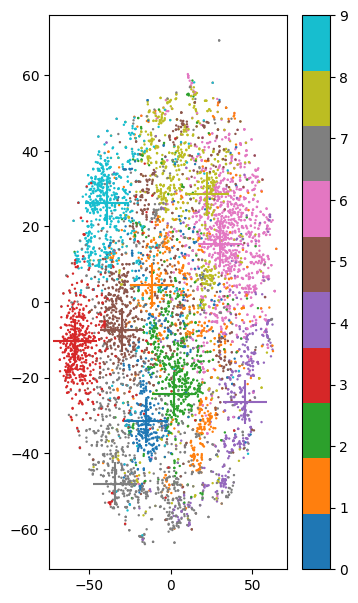

In [53]:
pointsclusters = np.zeros((10, 2))

for i in range(10):
    pointsclusters[i,:] = points2D[int(indclusters[i][0])]

cmap = cm.tab10
plt.figure(figsize=(3.841, 7.195), dpi=100)
plt.set_cmap(cmap)
plt.subplots_adjust(hspace=0.4 )
plt.scatter(points2D[:,0], points2D[:,1], c=clustersID,  s=3, edgecolors='none', cmap=cmap, alpha=1.0)
plt.scatter(pointsclusters[:,0], pointsclusters[:,1], c=range(10), marker='+', s=1000, edgecolors='none', cmap=cmap, alpha=1.0)

plt.colorbar(ticks=range(10))
plt.show()

/tmp/ipykernel_55/24501469.py:6: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pointsclusters[:,0], pointsclusters[:,1], c=range(10), marker='+', s=1000, edgecolors='none', cmap=cmap, alpha=1.0)


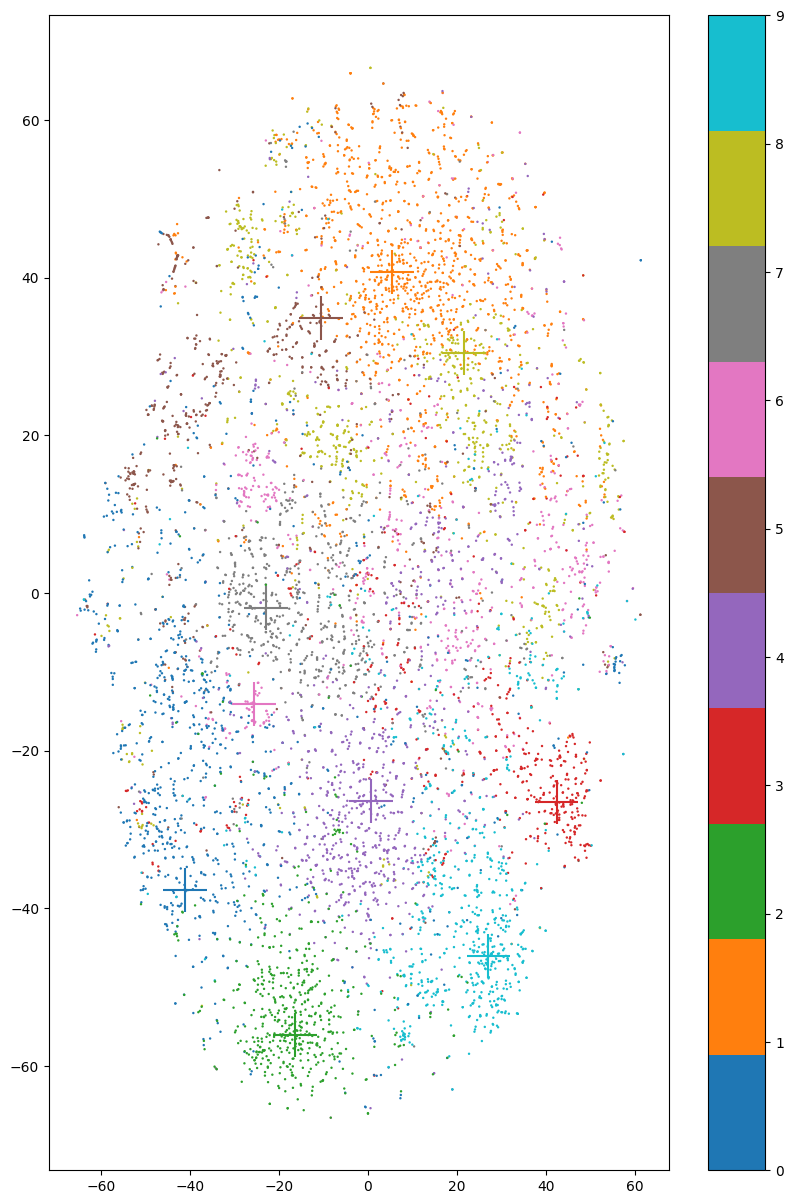

In [15]:
cmap = cm.tab10
plt.figure(figsize=(10, 15), dpi=100)
plt.set_cmap(cmap)
plt.subplots_adjust(hspace=0.4 )
plt.scatter(points2D[:,0], points2D[:,1], c=clustersID,  s=3, edgecolors='none', cmap=cmap, alpha=1.0)
plt.scatter(pointsclusters[:,0], pointsclusters[:,1], c=range(10), marker='+', s=1000, edgecolors='none', cmap=cmap, alpha=1.0)

plt.colorbar(ticks=range(10))
plt.show()